# Diffusion Model for Gaussian Mix

In [1]:
import torch 
import numpy as np
import tensorboard as tb 
import matplotlib.pyplot as plt
import scipy.stats as st
import random
from torch import optim, nn, utils, Tensor

import plotly.express as px
import pandas as pd
import torch
import lightning as L

from pytorch_lightning.loggers import TensorBoardLogger
from typing import Callable




In [2]:
# Setting a seed and setting the device


seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)


if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print("CUDA available — deterministic settings applied.")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is available — seed set, but determinism not guaranteed.")
else:
    device = torch.device("cpu")
    print("CPU-only — seed set.")

print("Device = ", device)

def set_seed(seed_value=42):
    np.random.seed(seed_value)
    random.seed(seed_value)
    torch.manual_seed(seed_value)



device = torch.device("cpu")

MPS is available — seed set, but determinism not guaranteed.
Device =  mps


## Defining the distribution to be simulated and the dataset 

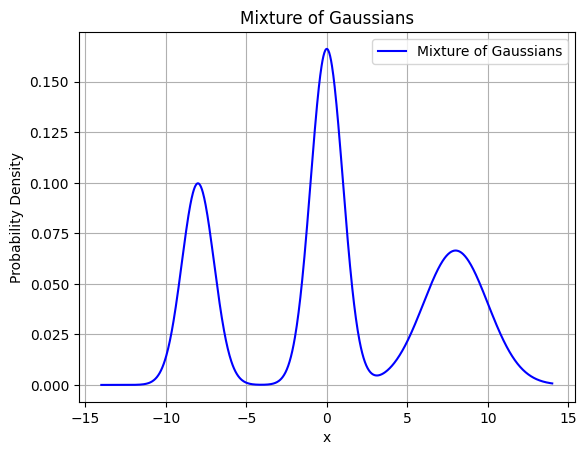

In [3]:
means = np.array([-8, 0, 8])         
stds = np.array([1, 1, 2])           
weights = np.array([1/4, 5/12, 1/3]) 
var = stds ** 2

means_tensor = torch.tensor(means, device=device, dtype=torch.float32)
var_tensor = torch.tensor(var, device=device, dtype=torch.float32)
weights_tensor = torch.tensor(weights, device=device, dtype=torch.float32)

gaussian1 = st.norm(loc=means[0], scale=stds[0])
gaussian2 = st.norm(loc=means[1], scale=stds[1])
gaussian3 = st.norm(loc=means[2], scale=stds[2])


x = np.linspace(-14, 14, 1000) 
pdf1 = gaussian1.pdf(x)
pdf2 = gaussian2.pdf(x)
pdf3 = gaussian3.pdf(x)

mixed_pdf = weights[0] * pdf1 + weights[1] * pdf2 + weights[2] * pdf3


plt.plot(x, mixed_pdf, label="Mixture of Gaussians", color='blue')

plt.title("Mixture of Gaussians")
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.show()




In [4]:

def dataset_gen(weights: np.ndarray, means: np.ndarray = np.array([0, 0, 0]), stds: np.ndarray = np.array([1, 1, 1]), device: torch.device = torch.device('cpu'), size: int = 1000) -> torch.Tensor:
    """
    We generate a gaussian mixture using weights, means and std. 
    The result is a sample of the gaussian mix.
    """
    
    chosen_dists = np.random.choice(len(weights), size=size, p=weights)
    samples = np.random.normal(means[chosen_dists], stds[chosen_dists])
    return torch.tensor(samples, dtype=torch.float32, device=device).unsqueeze(1)


n = 10000
x_0 = dataset_gen(weights = weights, means = means, stds = stds, device = device, size = n )

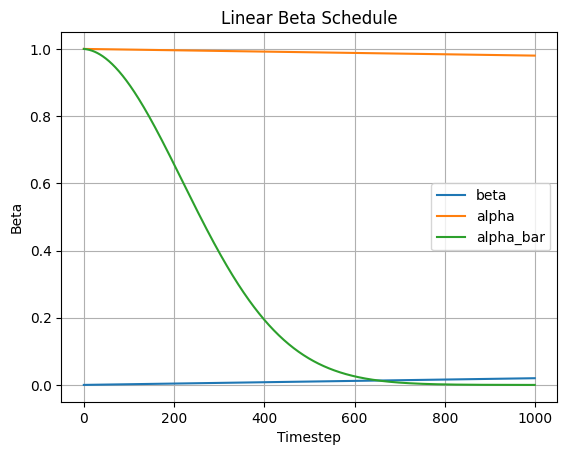

In [5]:

def linear_beta_scheduler(timesteps: int, start: float = 1e-4, end: float = 0.02):
    return torch.linspace(start, end, timesteps, device = device)

timesteps = 1000
start = 0.0001
end = 0.02
beta =  linear_beta_scheduler(timesteps,start = start, end = end)
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)

plt.plot(beta.cpu().numpy(), label = "beta")
plt.plot(alpha.cpu().numpy(), label = "alpha")
plt.plot(alpha_bar.cpu().numpy(), label = "alpha_bar")
plt.title("Linear Beta Schedule")
plt.xlabel("Timestep")
plt.ylabel("Beta")
plt.legend()
plt.grid(True)
plt.show()

## Defining the noising function and visualizing the noising process

In [6]:
def noising(t_index : torch.Tensor, x_0: torch.Tensor, alpha_bar: torch.Tensor, seed : int = None, noise : torch.tensor = None) -> torch.Tensor:
    """ 
    This function defines the noising process from a batch tensor of x_0
    x_0 is supposed to be of size batch_size x x_size
    t is supposed to be of size batch_size
    Attention to t_index, tensor are indexed with a shift of -1 in comparaison to timesteps. 
    If we pass the indexes we should just perform alpha_bar[t_index], if we pass time steps we should do alpha_bar[t_index -1]
    """
    
    if noise is None:
        noise = torch.randn_like(x_0, device=x_0.device)

    alpha_bar_t = alpha_bar[t_index].view(-1, *[1] * (x_0.dim() - 1))
        

    return torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise    


In [ ]:
data = []
i = 1
for t in range(0, timesteps, 5):
    t_index = torch.full((x_0.shape[0],), t, device=device)
    noised = noising(t_index, x_0, alpha_bar, seed=42)
    for val in noised.flatten().cpu().numpy():
        data.append({'value': val, 'timestep': t})
    

df = pd.DataFrame(data)

fig = px.histogram(df, x='value', animation_frame='timestep', nbins = 90, histnorm='probability density', range_x=[-10, 15])

fig.update_layout(
    title=f"Empirical distribution of the dataset during noising",
    xaxis_title="Value",
    yaxis_title="Density",
    showlegend=False,
    yaxis=dict(range=[0, 0.4]),
    xaxis=dict(range=[-7, 15])

)

fig.show()

## Generation

In [ ]:
def generate_with_noiser(size: int = 100, seed: int = None, x_t: torch.Tensor = None, 
                        noiser: Callable = None, beta: torch.Tensor = None, alpha_bar : torch.Tensor = None,
                        timesteps : int = None,
                        alpha : torch.Tensor = None, normalized : bool = False, mean : float = None, std : float = None ) -> list:  
    
    
    """
    Generation of the sample using the instructions for the noiser given by arXiv:2006.11239v2
    """
    
    if seed is not None:
        torch.manual_seed(seed)
    
    alpha_bar_minus = nn.functional.pad(
            alpha_bar[:-1], (1, 0), value=1.0)
    sigma = torch.sqrt(beta * (1.0 - alpha_bar_minus) / (1.0 - alpha_bar))


    if x_t is None: 
        x_t = torch.randn(size, 1, device=device)



    if isinstance(noiser, nn.Module):
        noiser.eval()
    

    with torch.no_grad():
        for t in reversed(range(timesteps)): 
            t_index = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)

            noise = noiser(x_t, t_index)
            
            z = torch.randn_like(x_t) if t > 0 else 0.0

            coef = (1 - alpha[t]) / torch.sqrt(1 - alpha_bar[t])
            
            x_t = (
                (1 / torch.sqrt(alpha[t]))
                * (x_t - coef * noise)
                + sigma[t] * z
            )
            # x.append(x_t.clone().detach())
    if normalized:
        return x_t.flatten()*std + mean
    else:
        return x_t.flatten()
    
    
    
def generation_through_real_score(size: int = 100, seed: int = None, x_t: torch.Tensor = None, score: Callable = None,
                                beta: torch.Tensor = None,timesteps: int = 1000, normalized : bool = False, mean : float = None, 
                                std : float = None ) -> torch.Tensor:    
    
    
    if score is nn.Module:
        score.eval()
        
        
    if seed is not None:
        torch.manual_seed(seed)
    
    
    if x_t is None:
        x_t = torch.randn(size, device=device)
    x_t = x_t.flatten()

    with torch.no_grad():
        for t in reversed(range(timesteps)):
            score_t = score(x_t, t)
            z = torch.randn_like(x_t)
            x_t = (1 / torch.sqrt(1 - beta[t])) * (x_t + beta[t] * score_t) + torch.sqrt(beta[t]) * z
            
    if normalized:
        return x_t * std + mean
    else:   
        return x_t




IndentationError: expected an indented block after 'if' statement on line 60 (724282247.py, line 61)

## Analytical Score

If we want to compute the score for a Gaussian mixture  
$$
X_0 = \sum_{i = 1}^{K} Z_i \, \mathbb{1}_{\{I = i\}},
$$  
where each component $ Z_i \sim \mathcal{N}(\mu_i, \sigma_i^2) $,

then the noised variable $ X_t $ at time $ t $ has the distribution  
$$
X_t = \sum_{i = 1}^{K} \bar{Z}_i \, \mathbb{1}_{\{I = i\}},
$$  
with  
$$
\bar{Z}_i \sim \mathcal{N}\left(\sqrt{\bar{\alpha}_t} \mu_i,\; \bar{\alpha}_t \sigma_i^2 + (1 - \bar{\alpha}_t)\right).
$$

In [ ]:
import math

def normal_pdf(x: torch.Tensor, mean: torch.Tensor, var: torch.Tensor) -> torch.Tensor:
    """
    Vectorized computation of Gaussian density univariate.
    Input tensor x is of shape N (N data points)
    Input tensor mean is of shape M (M components)
    Input tensor var is of shape M (M components)
    Output tensor is of shape N x M (N data points, M components)
    """
    
    x = torch.atleast_1d(x)
    mean = torch.atleast_1d(mean)
    var = torch.atleast_1d(var)
    
    # Reshape for broadcasting
    x = x.unsqueeze(-1)  # Shape becomes N x 1
    mean = mean.unsqueeze(0)  # Shape becomes 1 x M
    var = var.unsqueeze(0)  # Shape becomes 1 x M
    
    coeff = 1.0 / (torch.sqrt(2 * torch.pi * var))
    
    exponent = - (x - mean) ** 2 / (2 * var)
    
    return coeff * torch.exp(exponent)

def density_mix_gaussian(x : torch.Tensor, means : torch.Tensor, var : torch.Tensor, weights : torch.Tensor) -> torch.Tensor:
    
    """
    Vectorized computation of the density of a Gaussian mixture.
    Input tensor x is of shape N
    Input tensor means is of shape M
    Input tensor stds is of shape M
    Input tensor weights is of shape M
    Output tensor is of shape N
    """
    
    x = torch.atleast_1d(x)
    means = torch.atleast_1d(means)
    var = torch.atleast_1d(var)
    weights = torch.atleast_1d(weights)
    
    
    weights = weights / weights.sum()
    
    density_normal = normal_pdf(x, means, var)
    
    weights = weights[torch.newaxis, :]
    

    density = torch.sum(density_normal * weights, dim=1)
    
    
    return density

def score_mix_gaussian(x: torch.Tensor, means: torch.Tensor, var: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
    
    denominator = density_mix_gaussian(x, means, var, weights)  # shape N
    density = normal_pdf(x, means, var)  # shape N x M
    
    density_weights = density * weights[torch.newaxis, :]  # shape N x M

    x = x[:, torch.newaxis]  # shape N x 1
    means = means[torch.newaxis, :]  # shape 1 x M
    var = var[torch.newaxis, :]  # shape 1 x M
    
    derivative = (means - x) / var  # shape N x M
    derivative = derivative * density_weights  # shape N x M
    
    # Compute the numerator of the score
    numerator = torch.sum(derivative, dim=1)  # shape N
    
    # Compute the score
    score_value = numerator / denominator  # shape N
    
    return score_value
    

In [ ]:

def score_mix_gaussian_factory(alpha_bar: torch.Tensor, means: torch.Tensor, var: torch.Tensor, weights: torch.Tensor):
    """
    Factory function to create the score function with fixed means, variances, and weights.
    Returns a score function that can be used to calculate the score at time t.
    """
    
    def score(x_t: torch.Tensor, t: int) -> torch.Tensor:
        """
        Computes the score of the mixture of Gaussians at time t.
        """
        x_t = torch.atleast_1d(x_t)  # shape N
        
        means_t = means * math.sqrt(alpha_bar[t])  # shape M x D
        
        var_t = (1 - alpha_bar[t]) + var * alpha_bar[t]  # shape M  
        
        
        return score_mix_gaussian(x_t, means_t, var_t, weights)  # shape N
    
    return score
    



## Generation using as score function the analytical score

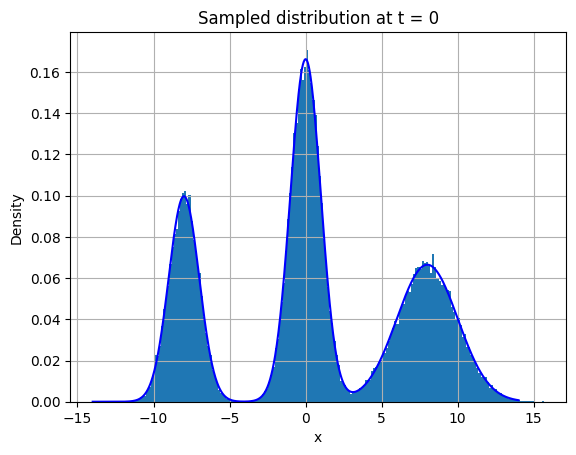

In [ ]:

score_function = score_mix_gaussian_factory(alpha_bar, means_tensor, var_tensor, weights_tensor)



size = 100000


generated_samples = generation_through_real_score(
    size=size,
    score=score_function,
    beta=beta,
    timesteps=timesteps
)

plt.hist(generated_samples.cpu().numpy(), bins=200, density=True)
plt.plot(x, mixed_pdf, label="Mixture of Gaussians", color='blue')

plt.title("Sampled distribution at t = 0")
plt.xlabel("x")
plt.ylabel("Density")
plt.grid(True)
plt.show()


## Introducing a Neural Net to estimate the score or the noise

In [ ]:
# Definition of the model
"""
class ScoreEstimator(L.LightningModule):
    
    def __init__(self, time_dim, x_dim, hidden_dim):
        super().__init__()
        self.x_dim = x_dim
        self.time_dim = time_dim
        self.layer1 = nn.Linear(x_dim + time_dim, hidden_dim)
        self.activation = nn.ReLU()
        self.layer2 = nn.Linear(hidden_dim, x_dim)
        
        
    def forward(self,x,t) : 
        x_t = torch.cat([x,t], dim=1)
        y = self.layer1(x_t)
        y = self.activation(y)
        return self.layer2(y)
    
    def training_step(self, batch):
        noise = torch.randn_like(batch, device = batch.device) 
        t = torch.randint(0, timesteps, size=(batch.shape[0],), device=batch.device)   
        noised = noising(t_index = t , x_0 = batch, alpha_bar = alpha_bar, noise = noise) 
        loss = nn.functional.mse_loss(noise, self.forward(noised,t.unsqueeze(1)))
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

score = ScoreEstimator(1,1,32)
"""


"\nclass ScoreEstimator(L.LightningModule):\n    \n    def __init__(self, time_dim, x_dim, hidden_dim):\n        super().__init__()\n        self.x_dim = x_dim\n        self.time_dim = time_dim\n        self.layer1 = nn.Linear(x_dim + time_dim, hidden_dim)\n        self.activation = nn.ReLU()\n        self.layer2 = nn.Linear(hidden_dim, x_dim)\n        \n        \n    def forward(self,x,t) : \n        x_t = torch.cat([x,t], dim=1)\n        y = self.layer1(x_t)\n        y = self.activation(y)\n        return self.layer2(y)\n    \n    def training_step(self, batch):\n        noise = torch.randn_like(batch, device = batch.device) \n        t = torch.randint(0, timesteps, size=(batch.shape[0],), device=batch.device)   \n        noised = noising(t_index = t , x_0 = batch, alpha_bar = alpha_bar, noise = noise) \n        loss = nn.functional.mse_loss(noise, self.forward(noised,t.unsqueeze(1)))\n        self.log('train_loss', loss, prog_bar=True)\n        return loss\n\n    def configure_optim

In [ ]:
# Training the model
"""
a
trainer = L.Trainer(max_epochs=1)

trainer.fit(model=score, train_dataloaders=train_loader)
"""

'\na\ntrainer = L.Trainer(max_epochs=1)\n\ntrainer.fit(model=score, train_dataloaders=train_loader)\n'

In [ ]:
class NoiseEstimator(nn.Module):
    
    def __init__(self, time_dim=4, x_emb_dim=5, hidden_dim=64, timesteps=1000, device = 'cpu'):
        super().__init__()
        self.device = device

        self.time_embedding = nn.Embedding(timesteps, time_dim).to(device)
        self.time_dim = time_dim
        self.net_x = nn.Linear(1, x_emb_dim).to(device)
        self.net = nn.Sequential(
            nn.Linear(x_emb_dim + time_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 1)
        ).to(device)
    
    def forward(self, x, t):
        x = x.to(self.device)
        t = t.to(self.device)

        x_emb = self.net_x(x)
        t_emb = self.time_embedding(t)
        x_t = torch.cat([x_emb, t_emb], dim=-1)

        return self.net(x_t)

NetNoise = NoiseEstimator(time_dim=20, x_emb_dim=20, hidden_dim=150, timesteps=timesteps, device=device)

In [ ]:
x_0_mean =  x_0.flatten().mean(dim=0)
x_0_std = x_0.flatten().std(dim=0)
x_0_training = (x_0 - x_0_mean) / x_0_std


train_loader = utils.data.DataLoader(x_0_training, batch_size=32)

def train(model, dataloader, timesteps, alpha_bar, noising, epochs=500, lr=1e-4, device='cuda'):
    
    """
    This function simply implements the training of the noiser model
    
    Training using the instructions given by arXiv:2006.11239v2
    
    """
    
    
    
    model = model.to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            batch = batch.to(device)
            noise = torch.randn_like(batch)
            t = torch.randint(1, timesteps, size=(batch.shape[0],), device=batch.device)
            noised = noising(t_index=t, x_0=batch, alpha_bar=alpha_bar, noise=noise)
            pred_noise = model(noised, t)
            loss = nn.functional.mse_loss(pred_noise, noise)
        
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()*batch.shape[0]
            
        print(f"Epoch {epoch+1}: Loss = {total_loss / len(dataloader.dataset)}")
    
    model.eval()
    

In [ ]:
train(model = NetNoise, dataloader = train_loader, epochs = 1000, timesteps = timesteps, alpha_bar = alpha_bar, noising =  noising, lr = 1e-4, device = device )

Epoch 1: Loss = 0.27285145795345306
Epoch 2: Loss = 0.27390033317804335
Epoch 3: Loss = 0.2602053543806076
Epoch 4: Loss = 0.2806989153385162
Epoch 5: Loss = 0.26832168135643003
Epoch 6: Loss = 0.27478865737915037
Epoch 7: Loss = 0.26187744517326356
Epoch 8: Loss = 0.27618854051828384
Epoch 9: Loss = 0.26907458713054655
Epoch 10: Loss = 0.26106706055402756
Epoch 11: Loss = 0.276653453707695
Epoch 12: Loss = 0.2574673850774765
Epoch 13: Loss = 0.26516867516040804
Epoch 14: Loss = 0.27070278269052506
Epoch 15: Loss = 0.2762345868229866
Epoch 16: Loss = 0.2737889589190483
Epoch 17: Loss = 0.2629620164513588
Epoch 18: Loss = 0.26992400957345963
Epoch 19: Loss = 0.256004000544548
Epoch 20: Loss = 0.26697811409235
Epoch 21: Loss = 0.2678223442554474
Epoch 22: Loss = 0.2701123625636101
Epoch 23: Loss = 0.25772586812973025
Epoch 24: Loss = 0.2690328192472458
Epoch 25: Loss = 0.27326224000453947
Epoch 26: Loss = 0.2760295952796936
Epoch 27: Loss = 0.255981321144104
Epoch 28: Loss = 0.2695639885

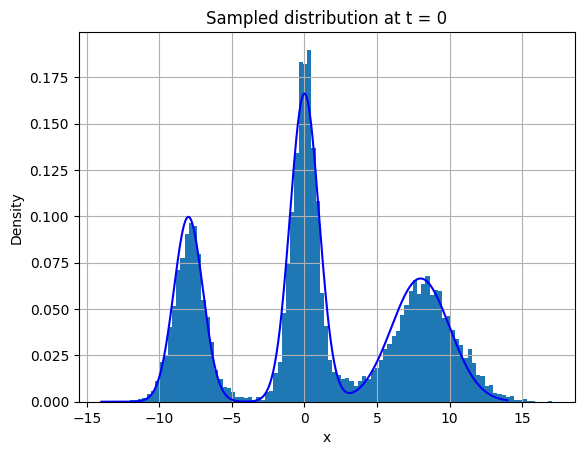

In [ ]:
x_0_sampled = generate_with_noiser(size =  10000,  noiser = NetNoise, mean = x_0_mean, std = x_0_std, normalized = True , beta = beta, alpha_bar = alpha_bar, alpha = alpha, timesteps = timesteps)



plt.hist(x_0_sampled.cpu().numpy(), bins=100, density=True)
plt.plot(x, mixed_pdf, label="Mixture of Gaussians", color='blue')

plt.title("Sampled distribution at t = 0")
plt.xlabel("x")
plt.ylabel("Density")
plt.grid(True)
plt.show()